### A simple fMRI analysis using SPM with nipype

Resources: 
     - https://miykael.github.io/nipype_tutorial/notebooks/introduction_showcase.html
     - https://pythonhosted.org/nipype/users/examples/fmri_spm_face.html
     - https://miykael.github.io/nipype_tutorial/notebooks/handson_analysis.html
     
     
A faire
 - utiliser MCR

In [1]:
from nipype import Node, Workflow
import os
import nipype.interfaces.matlab as mlab

Failed to import duecredit due to No module named 'duecredit'


In [2]:
# Set the way matlab should be called -- TODO
mlab.MatlabCommand.set_default_matlab_cmd("/Applications/MATLAB_R2017a.app/bin/matlab -nodesktop -nosplash")
# If SPM is not in your MATLAB path you should add it here
mlab.MatlabCommand.set_default_paths(os.path.join(os.getcwd(), '..', '..', 'spm8'))

In [3]:
from nipype.interfaces.spm import Segment, SliceTiming, Realign, Coregister, Normalize, Smooth
from nipype.interfaces.fsl import ExtractROI

In [4]:
# Defaults

tr = 2.5;
ta = 2.5;

num_img_stab = 2;

num_slices = 30

# FIS_UNITS = 'secs';

# FIS_CONDITIONS{1} = struct(...
#     'sessName', 'se_fingerfootlips',...
#     'condnames', {'finger'},...
#     'onsets', {(10:90:430) - NUM_IMG_STAB.nBeg*TR},...
#     'duration',{15});

# FIS_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# INFORMED_BASIS_SET = false;

# FIS_THRESHOLDS{1} = struct('threshdesc', 'none', 'thresh', 0.001);

# GU_CONTRASTS{1} = struct(...
#     'contrastName', 'cn_figer', ...
#     'name', 'Motor finger: group activations', ...
#     'coninfo', 'co_finger', ...
#     'negative', true, ...
#     'nameNegative', 'Motor finger: deactivations',...
#     'sessrep', 'none');

# GU_THRESHOLDS{1} = struct('threshdesc', 'FWE', 'thresh', 0.05);

In [5]:
ds114 = os.path.join(os.getcwd(), '..', 'data', 'ds000114_R2.0.1')
base_output = os.path.join(os.getcwd(), '..', 'output', 'nipype')
preproc_folder =  'pre-processing'

### anatomical MRI preprocessing

In [6]:
segment = Node(Segment(save_bias_corrected=True), name="segment")

### fMRI preprocessing

In [7]:
TR=tr

# Slice order must start from 1 not zero (otherwise we get a Matlab error)

slicetiming = Node(SliceTiming(time_repetition=TR,
                             time_acquisition=TR - TR / float(num_slices),
                             num_slices = num_slices,
                             slice_order = list(range(1, num_slices+1, 2)) + list(range(2, num_slices+1, 2)), # TODO
                             ref_slice = int(num_slices / 2)), name="slicetiming")
realign = Node(Realign(), name = 'realign')
coreg = Node(Coregister(), name = 'coreg')
norm = Node(Normalize(), name = 'norm')
norm.inputs.jobtype = "write"
norm_anat = Node(Normalize(), name = 'norm_anat')
norm_anat.inputs.jobtype = "write"
smooth = Node(Smooth(), name = 'smooth')


In [8]:
len(list(range(0, num_slices, 2)) + list(range(1, num_slices, 2)))


30

In [9]:
from nipype.algorithms.misc import Gunzip

gunzip = Node(Gunzip(), name='gunzip')

In [10]:
# slicetiming.inputs.in_files = [one_fmri_file]
# segment.inputs.data = one_anat_file



In [11]:
# list of session identifiers
task_list = ['fingerfootlips']

In [12]:
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink


# list of subject identifiers
# subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
subject_list = ['01', '02']

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# Skip dummy scans
extract = Node(ExtractROI(t_min=num_img_stab, t_size=-1, output_type='NIFTI'),
               name="extract")

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = os.path.join('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_t1w.nii.gz')
func_file = os.path.join('sub-{subject_id}', 'ses-test', 'func',
                'sub-{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory=ds114),
                   name="selectfiles")

datasink = Node(DataSink(base_directory=base_output,
                         container=preproc_folder),
                name="datasink")

## Use the following substitutions for the DataSink output
substitutions = [('_subj_id_', 'su_')]
datasink.inputs.substitutions = substitutions

181122-17:05:35,597 nipype.workflow INFO:
	 Generated workflow graph: /Users/camaumet/Softs/fmri_example_pipelines/scripts/../output/nipype/preproc/graph.png (graph2use=colored, simple_form=True).


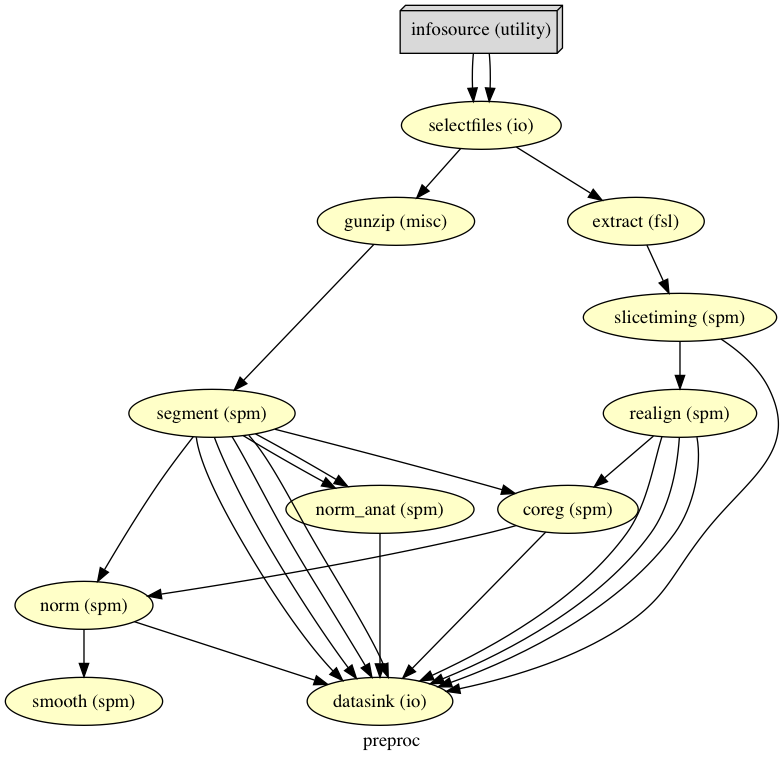

In [14]:
preproc = Workflow(name='preproc')
preproc.base_dir = os.path.join(base_output)

preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetiming, [('roi_file', 'in_files')]),
                 (slicetiming, realign, [('timecorrected_files', 'in_files')]),
                 (realign, coreg, [('mean_image', 'source')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, segment, [('out_file', 'data')]),
                 (segment, coreg, [('bias_corrected_image', 'target')]),
                 (coreg, norm, [('coregistered_source', 'source')]),
                 (norm, smooth, [('normalized_source', 'in_files')]),
                 (segment, norm, [('transformation_mat', 'parameter_file')]),
                 (segment, norm_anat, [('bias_corrected_image', 'source'),
                                       ('transformation_mat', 'parameter_file')])])

# Save outputs
preproc.connect([(slicetiming, datasink, [('timecorrected_files', 'functional.@slicetimed')]),
                 (realign, datasink, [('mean_image', 'functional.@realigned_mean'),
                                      ('realigned_files', 'functional.@realigned'),
                                      ('realignment_parameters', 'functional.@realigned_param')]),
                 (coreg, datasink, [('coregistered_files', 'functional.@coreg')]),
                 (norm, datasink, [('normalized_source', 'functional.@norm')]),
                 (norm_anat, datasink, [('normalized_source', 'anat.@norm')]),
                 (segment, datasink, [('bias_corrected_image', 'anat.@t1'),
                                      ('native_gm_image', 'anat.@gm'),
                                      ('native_wm_image', 'anat.@wm'),
                                      ('native_csf_image', 'anat.@csf')])
                 ])

preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(preproc.base_dir, 'preproc', 'graph.png'))



In [ ]:
preproc.run('MultiProc', plugin_args={'n_procs': 1})

181122-17:05:39,193 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
181122-17:05:39,267 nipype.workflow INFO:
	 Running in parallel.
181122-17:05:39,272 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-17:05:39,359 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/Users/camaumet/Softs/fmri_example_pipelines/output/nipype/preproc/_subject_id_02_task_name_fingerfootlips/selectfiles".
181122-17:05:39,379 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181122-17:05:39,397 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
181122-17:05:41,278 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).
181122-17:05:41,284 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-17:05:41,362 nipype.workflow INFO:

	 [Node] Setting-up "preproc.norm_anat" in "/Users/camaumet/Softs/fmri_example_pipelines/output/nipype/preproc/_subject_id_01_task_name_fingerfootlips/norm_anat".
181122-17:09:57,648 nipype.workflow INFO:
	 [Node] Outdated cache found for "preproc.norm_anat".
181122-17:09:57,787 nipype.workflow INFO:
	 [Node] Running "norm_anat" ("nipype.interfaces.spm.preprocess.Normalize")
181122-17:09:59,590 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 14.20/14.40, Free processors: 0/1.
                     Currently running:
                       * preproc.norm_anat
181122-17:10:25,670 nipype.workflow INFO:
	 [Node] Finished "preproc.norm_anat".
181122-17:10:27,613 nipype.workflow INFO:
	 [Job 14] Completed (preproc.norm_anat).
181122-17:10:27,618 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 1/1.
181122-17:10:27,666 nipype.workflow INFO:
	 [Job 15] Cached (preproc.extract).
181122-